In [ ]:
#python 3.12.3
#Recommendation: use micromamba for versions through dev enviornments

: 

# Monte Carlo as a tool for option pricing
Financial mathematics used in calculating risk-neutral pricing by simulating risk-neutral asset paths

This is done by discounting risk-free rate to calculate present value of option price for different paths

Goal: average out option price for the different paths produced by monte carlo

In [17]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.3/315.3 kB 12.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 8.6 MB/s eta 0:00:00
  Created wheel for frozendict: filename=frozendict-2.4.2-cp311-cp311-macosx_11_0_arm64.whl size=15503 sha256=8c4f40b48f7162cb5f61315bbbb7080e6a30cb17bfd26b082b007d7141a11f3d
  Stored in directory: /Users/labib/Library/Caches/pip/wheels/17

In [30]:
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end) # fetches data from yahoo finance
    stockData = stockData['Close']
    print(stockData)
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL',  'TSLA', 'BRK-A', 'NVDA', 'JPM', 'V', 'JNJ', 'PG', 'MA', 'UNH', 'INTC']


endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days = 300)
meanReturns, covMatrix = get_data(stocks, startDate, endDate)




[*********************100%%**********************]  14 of 14 completed

Ticker            AAPL        AMZN     BRK-A       GOOGL       INTC  \
Date                                                                  
2023-06-28  189.250000  129.039993  506650.0  120.180000  33.570000   
2023-06-29  189.589996  127.900002  512260.0  119.099998  32.910000   
2023-06-30  193.970001  130.360001  517810.0  119.699997  33.439999   
2023-07-03  192.460007  130.220001  519460.0  119.900002  33.619999   
2023-07-05  191.330002  130.380005  521000.0  121.750000  32.509998   
...                ...         ...       ...         ...        ...   
2024-04-16  169.380005  183.320007  598160.0  154.399994  36.259998   
2024-04-17  168.000000  181.279999  600300.0  155.470001  35.680000   
2024-04-18  167.039993  179.220001  604144.0  156.009995  35.040001   
2024-04-19  165.000000  174.630005  611244.0  154.089996  34.200001   
2024-04-22  165.839996  177.229996  617284.0  156.279999  34.410000   

Ticker             JNJ         JPM          MA        MSFT        NVDA  \
Da

Monte Carlo

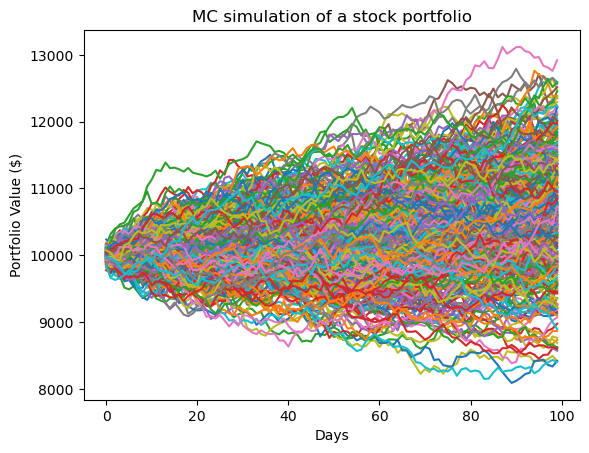

In [33]:

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

num_sim = 400
T = 100 # timeframe in days
meanM = np.full(shape=(T,len(weights)), fill_value=meanReturns)
meanM = meanM.T


portfolio_sims = np.full(shape=(T, num_sim), fill_value=0.0)
initialPortfolio = 10000

for m in range(0, num_sim):
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix) #cholesky decompostion to lower triangular matrix
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:, m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [43]:
def mcVaR(returns, alpha = 5) :
    """Input: pandas series of returns
    Output: percentile on return distribution to a given confidence level alpha"""
    if isinstance (returns, pd.Series) :
        return np.percentile(returns, alpha)
    raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha = 5):
    """
    Input: pandas series of returns
    Output: VaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance (returns, pd.Series):
        belowVaR= returns <= mcVaR(returns, alpha =alpha)
        return returns[belowVaR].mean()

    raise TypeError("Expected a pandas data series.")

portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults)
CVaR = initialPortfolio - mcCVaR(portResults)
print('Value at risk ${}'.format(round(VaR,2)))
print('Conditional value at risk ${}'.format(round(CVaR, 2)))

Value at risk $787.59
Conditional value at risk $1170.51
